# Step 1: Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Import Necessary Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report

# Step 3: Define Paths and Parameters

In [ ]:
# Define paths
train_path = '/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/Vehicles/train'  # Update with your path
val_path = '/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/Vehicles/val'      # Update with your path
test_path = '/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/Vehicles/test'    # Update with your path

# Parameters
IMG_SIZE = (128, 128)  # Standard size for many CNN models
BATCH_SIZE = 64
EPOCHS = 30
NUM_CLASSES = 7  # cab, tank, etc. (7 folders)

# Step 4: Data Preparation and Augmentation

In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names
class_names = list(train_generator.class_indices.keys())

Found 8698 images belonging to 7 classes.
Found 2459 images belonging to 7 classes.
Found 1183 images belonging to 7 classes.



Training Set Class Distribution:
cab: 811 images
fire_engine: 1333 images
horse_cart: 1297 images
recreational_vehicle: 1267 images
snowmobile: 1351 images
tank: 1340 images
unicycle: 1299 images


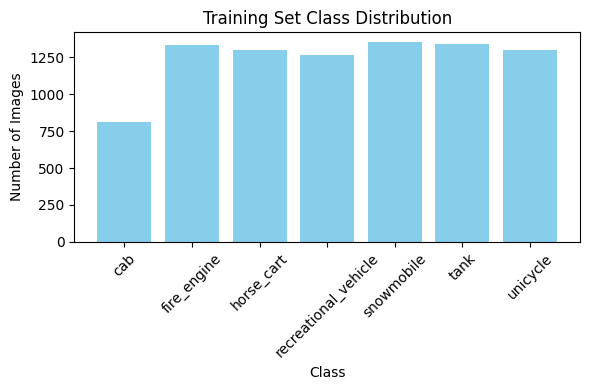


Validation Set Class Distribution:
cab: 388 images
fire_engine: 375 images
horse_cart: 393 images
recreational_vehicle: 405 images
snowmobile: 386 images
tank: 129 images
unicycle: 383 images


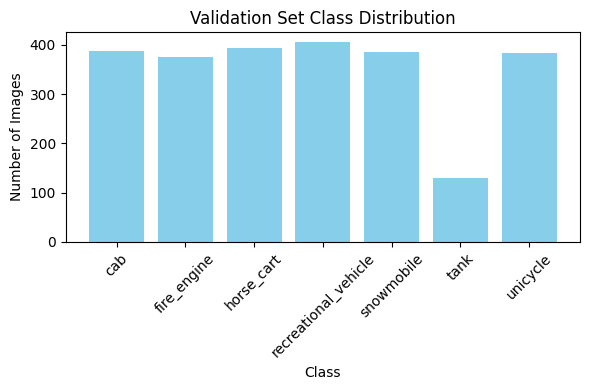


Test Set Class Distribution:
cab: 111 images
fire_engine: 148 images
horse_cart: 134 images
recreational_vehicle: 149 images
snowmobile: 125 images
tank: 372 images
unicycle: 144 images


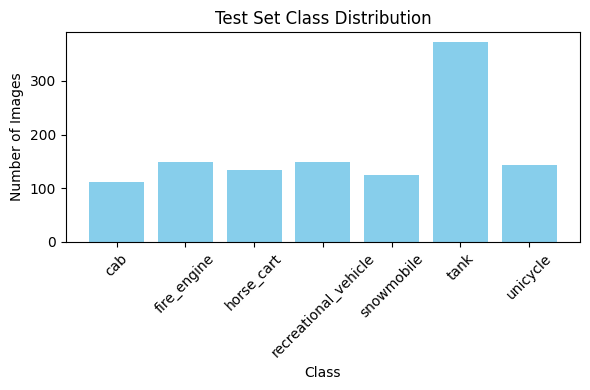

In [ ]:
# Function to count class distribution from a generator
def plot_class_distribution(generator, title):
    labels = generator.classes
    class_names = list(generator.class_indices.keys())
    counts = np.bincount(labels)

    print(f"\n{title} Set Class Distribution:")
    for i, count in enumerate(counts):
        print(f"{class_names[i]}: {count} images")

    # Plotting
    plt.figure(figsize=(6,4))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(f'{title} Set Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Check all sets
plot_class_distribution(train_generator, "Training")
plot_class_distribution(val_generator, "Validation")
plot_class_distribution(test_generator, "Test")

# Baseline CNN Model (Model 1)

In [ ]:
# 1. Baseline CNN Model (Simple Architecture)
def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1746811849.564047    1609 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1746811849.570842    1609 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,315,207 (12.65 MB)

 Trainable params: 3,315,207 (12.65 MB)

 Non-trainable params: 0 (0.00 B)

/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 964ms/step
Classification Report:
                      precision    recall  f1-score   support

                 cab       0.00      0.00      0.00       111
         fire_engine       0.00      0.00      0.00       148
          horse_cart       0.11      0.96      0.20       134
recreational_vehicle       0.05      0.01      0.01       149
          snowmobile       0.00      0.00      0.00       125
                tank       0.00      0.00      0.00       372
            unicycle       0.18      0.02      0.04       144

            accuracy                           0.11      1183
           macro avg       0.05      0.14      0.04      1183
        weighted avg       0.04      0.11      0.03      1183



/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

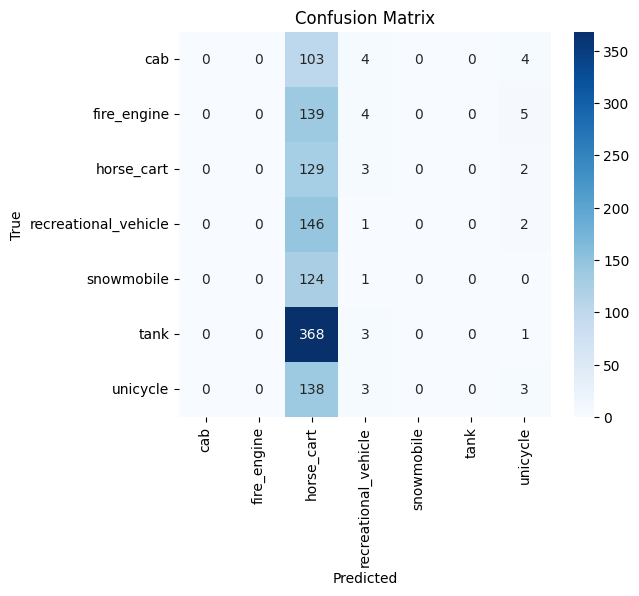

In [ ]:
# Evaluating the Baseline CNN Model

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# True labels and predictions
y_true = test_generator.classes
y_pred_probs = baseline_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (binary only)
if len(class_labels) == 2:
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


# Step 5: Build CNN Model


In [ ]:
# 2. Deeper CNN with BatchNorm, Dropout & Adam
def create_deep_model(optimizer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Using Adam
deep_model_adam = create_deep_model(Adam(learning_rate=0.0001))
deep_model_adam.summary()


/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,687 (10.50 MB)

 Trainable params: 2,750,727 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

# Deeper CNN with SGD (Model 2, SGD Variant)

In [ ]:
# 3. Deeper CNN Again, But With SGD
from tensorflow.keras.optimizers import Adam, SGD
deep_model_sgd = create_deep_model(SGD(learning_rate=0.01, momentum=0.9))
deep_model_sgd.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,687 (10.50 MB)

 Trainable params: 2,750,727 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

# Step 6: Define Callbacks Function to Train the Model

In [ ]:
# ---------------------------------------------
# Function to Train Any Model with Callbacks
# ---------------------------------------------
def train_model(model, name):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    model.save(f'{name}.h5')
    return history


# Step 7: Train All Models

In [ ]:
# Train All Models and Collect Histories
history_baseline = train_model(baseline_model, 'baseline_cnn')
history_deep_adam = train_model(deep_model_adam, 'deep_cnn_adam')
history_deep_sgd = train_model(deep_model_sgd, 'deep_cnn_sgd')


/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.1918 - loss: 1.9114 - val_accuracy: 0.3425 - val_loss: 1.7003 - learning_rate: 1.0000e-04
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 0.3438 - loss: 1.7105

/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.3438 - loss: 1.7105 - val_accuracy: 0.3302 - val_loss: 1.7081 - learning_rate: 1.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.3599 - loss: 1.6883 - val_accuracy: 0.4346 - val_loss: 1.5205 - learning_rate: 1.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.5156 - loss: 1.3522 - val_accuracy: 0.4145 - val_loss: 1.5421 - learning_rate: 1.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.4205 - loss: 1.5473 - val_accuracy: 0.5329 - val_loss: 1.3705 - learning_rate: 1.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 169ms/step - accuracy: 0.4844 - loss: 1.4701 - val_accuracy: 0.5234 - val_loss: 1.3796 - learning_rate: 1.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.4575 - loss: 1.4726 - val_accuracy: 0.5555 - val_loss: 1.3024 - learning_rate: 1.0000e-04
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accura

Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.2788 - loss: 2.4397 - val_accuracy: 0.1451 - val_loss: 2.9180 - learning_rate: 1.0000e-04
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 0.2812 - loss: 1.8797 - val_accuracy: 0.1456 - val_loss: 2.8987 - learning_rate: 1.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.3981 - loss: 1.6225 - val_accuracy: 0.1760 - val_loss: 2.7868 - learning_rate: 1.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 38s 283ms/step - accuracy: 0.3125 - loss: 1.7598 - val_accuracy: 0.1772 - val_loss: 2.7652 - learning_rate: 1.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.4275 - loss: 1.5510 - val_accuracy: 0.2323 - val_loss: 2.1238 - learning_rate: 1.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 36s 267ms/step - accuracy: 0.4531 - loss: 1.6711 - val_accuracy: 0.2311 - val_loss: 2.1106 - learning_rate: 1.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step

Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.2482 - loss: 2.3967 - val_accuracy: 0.2048 - val_loss: 1.9511 - learning_rate: 0.0100
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 206ms/step - accuracy: 0.3438 - loss: 1.7834 - val_accuracy: 0.2175 - val_loss: 1.9501 - learning_rate: 0.0100
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3464 - loss: 1.7410 - val_accuracy: 0.2595 - val_loss: 1.9297 - learning_rate: 0.0100
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - accuracy: 0.4375 - loss: 1.5839 - val_accuracy: 0.2775 - val_loss: 1.8991 - learning_rate: 0.0100
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.3545 - loss: 1.7228 - val_accuracy: 0.3540 - val_loss: 1.6791 - learning_rate: 0.0100
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.4688 - loss: 1.6294 - val_accuracy: 0.3647 - val_loss: 1.6647 - learning_rate: 0.0100
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.3805 - lo

# Step 8: Evaluate Function and Evaluating Model


Evaluating Baseline CNN
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 688ms/step - accuracy: 0.6861 - loss: 0.9848
Baseline CNN - Test Accuracy: 61.54%
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 751ms/step
                      precision    recall  f1-score   support

                 cab       0.71      0.65      0.68       111
         fire_engine       0.55      0.85      0.66       148
          horse_cart       0.43      0.62      0.51       134
recreational_vehicle       0.54      0.68      0.61       149
          snowmobile       0.65      0.74      0.69       125
                tank       0.88      0.54      0.67       372
            unicycle       0.53      0.35      0.42       144

            accuracy                           0.62      1183
           macro avg       0.61      0.63      0.60      1183
        weighted avg       0.66      0.62      0.62      1183



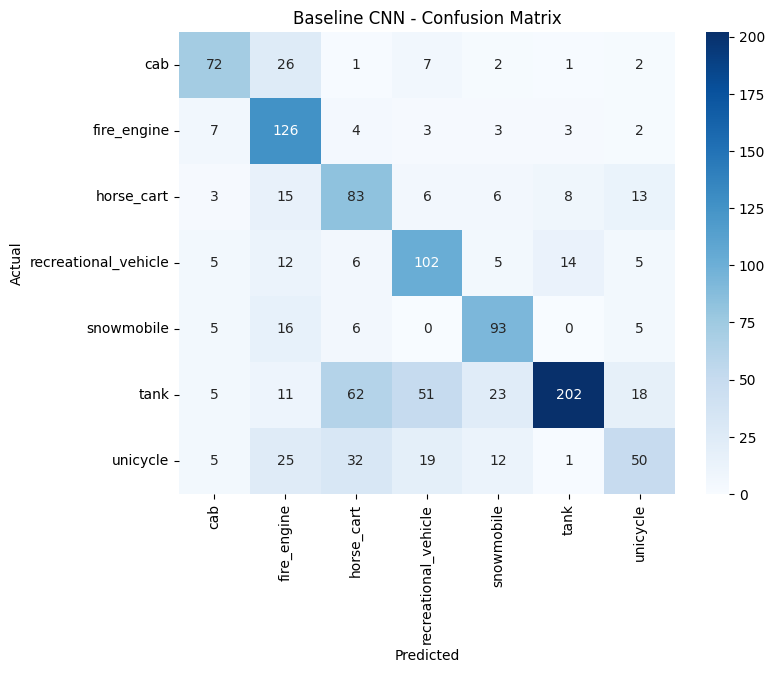


Evaluating Deeper CNN (Adam)
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 757ms/step - accuracy: 0.7225 - loss: 0.8425
Deeper CNN (Adam) - Test Accuracy: 68.05%
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 745ms/step
                      precision    recall  f1-score   support

                 cab       0.53      0.69      0.60       111
         fire_engine       0.70      0.80      0.74       148
          horse_cart       0.49      0.73      0.59       134
recreational_vehicle       0.66      0.66      0.66       149
          snowmobile       0.79      0.75      0.77       125
                tank       0.89      0.69      0.78       372
            unicycle       0.55      0.43      0.48       144

            accuracy                           0.68      1183
           macro avg       0.66      0.68      0.66      1183
        weighted avg       0.71      0.68      0.68      1183



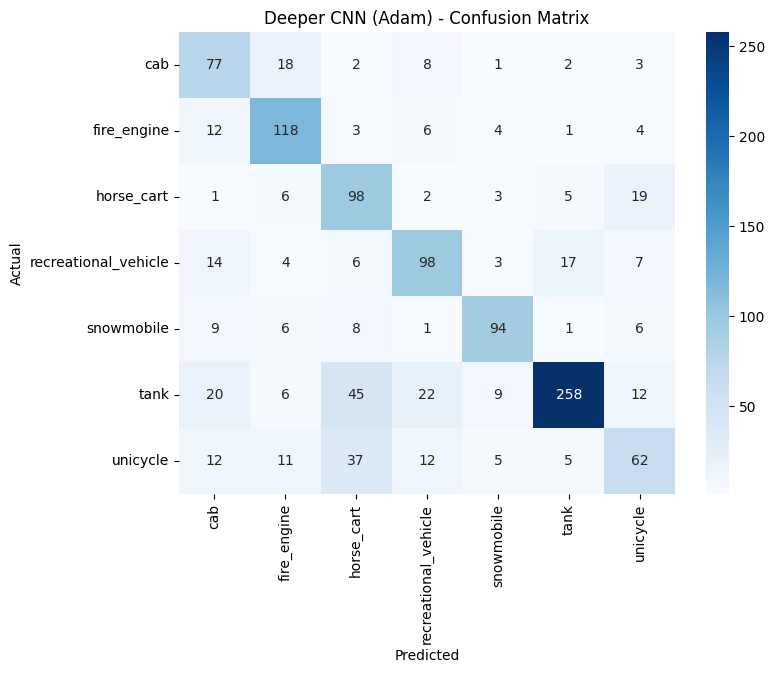


Evaluating Deeper CNN (SGD)
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 773ms/step - accuracy: 0.6675 - loss: 0.9988
Deeper CNN (SGD) - Test Accuracy: 64.41%
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step
                      precision    recall  f1-score   support

                 cab       0.63      0.59      0.61       111
         fire_engine       0.64      0.79      0.70       148
          horse_cart       0.49      0.58      0.53       134
recreational_vehicle       0.52      0.68      0.59       149
          snowmobile       0.75      0.76      0.75       125
                tank       0.83      0.68      0.75       372
            unicycle       0.47      0.36      0.41       144

            accuracy                           0.64      1183
           macro avg       0.62      0.63      0.62      1183
        weighted avg       0.66      0.64      0.64      1183



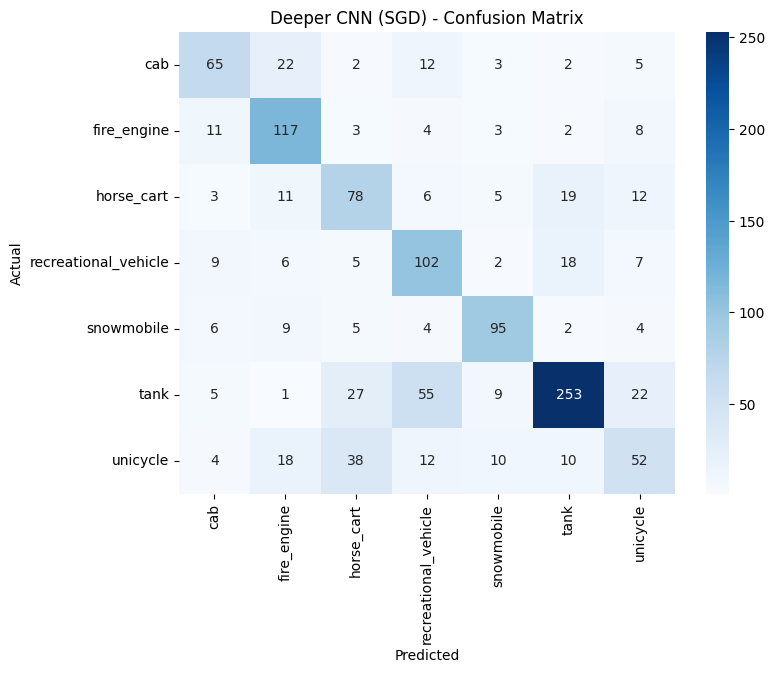

In [ ]:
# Unified Evaluation Function for All Models

def evaluate_model(model, name):
    print(f"\nEvaluating {name}")
    loss, acc = model.evaluate(test_generator)
    print(f'{name} - Test Accuracy: {acc * 100:.2f}%')

    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


evaluate_model(baseline_model, "Baseline CNN")
evaluate_model(deep_model_adam, "Deeper CNN (Adam)")
evaluate_model(deep_model_sgd, "Deeper CNN (SGD)")

# Step 9: plotting Training Histories for Comparison

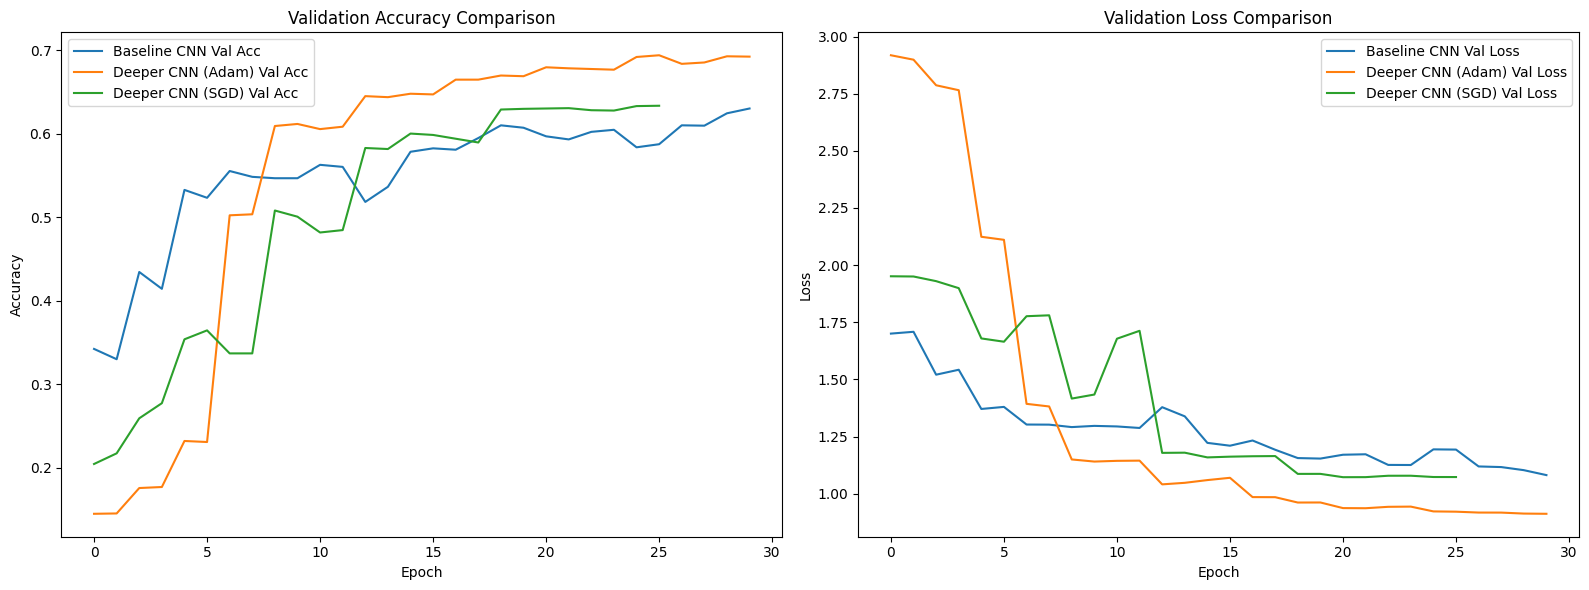

In [ ]:
# Plot Accuracy and Loss Curves for Visual Comparison

def plot_all_histories(histories, labels):
    plt.figure(figsize=(16, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_all_histories(
    [history_baseline, history_deep_adam, history_deep_sgd],
    ['Baseline CNN', 'Deeper CNN (Adam)', 'Deeper CNN (SGD)']
)


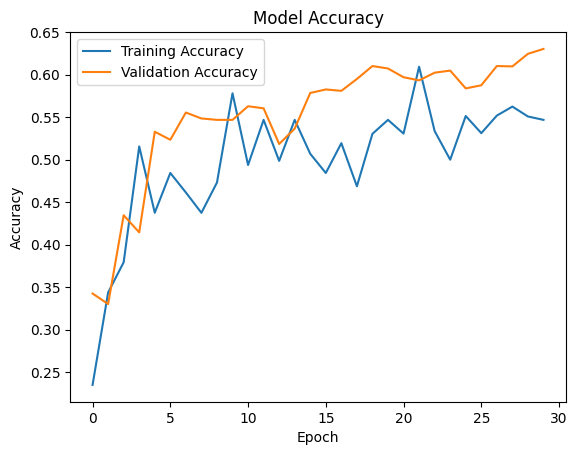

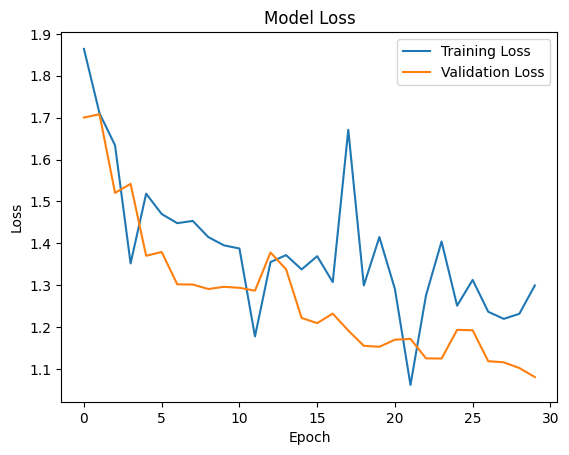

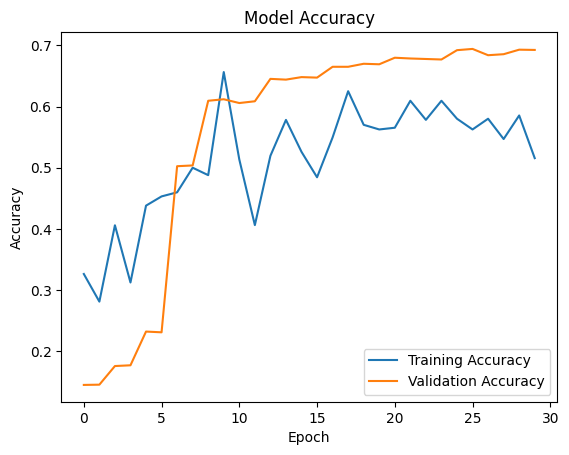

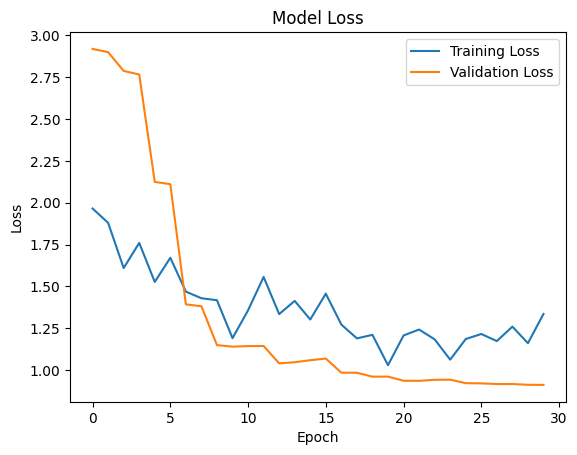

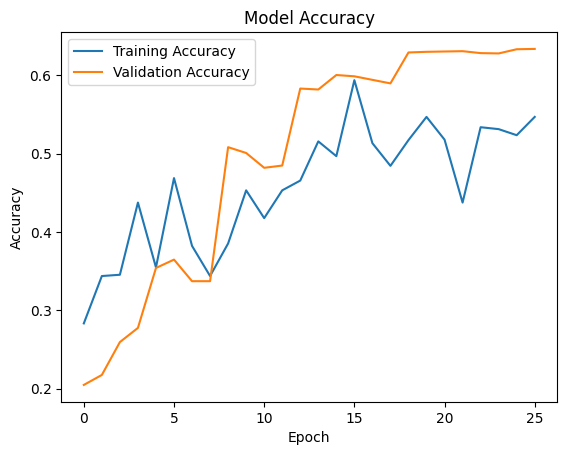

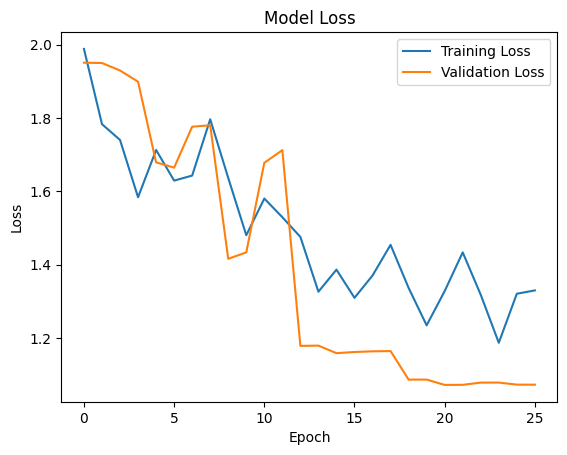

In [ ]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_baseline)
plot_history(history_deep_adam)
plot_history(history_deep_sgd)

# Step 9: Generate Confusion Matrix


19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 699ms/step


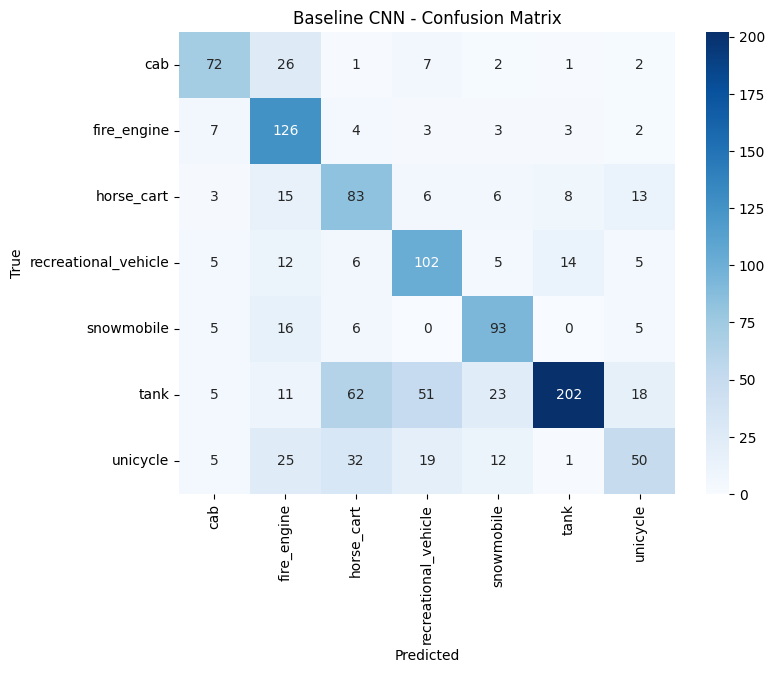

Baseline CNN - Classification Report:
                      precision    recall  f1-score   support

                 cab       0.71      0.65      0.68       111
         fire_engine       0.55      0.85      0.66       148
          horse_cart       0.43      0.62      0.51       134
recreational_vehicle       0.54      0.68      0.61       149
          snowmobile       0.65      0.74      0.69       125
                tank       0.88      0.54      0.67       372
            unicycle       0.53      0.35      0.42       144

            accuracy                           0.62      1183
           macro avg       0.61      0.63      0.60      1183
        weighted avg       0.66      0.62      0.62      1183

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 741ms/step


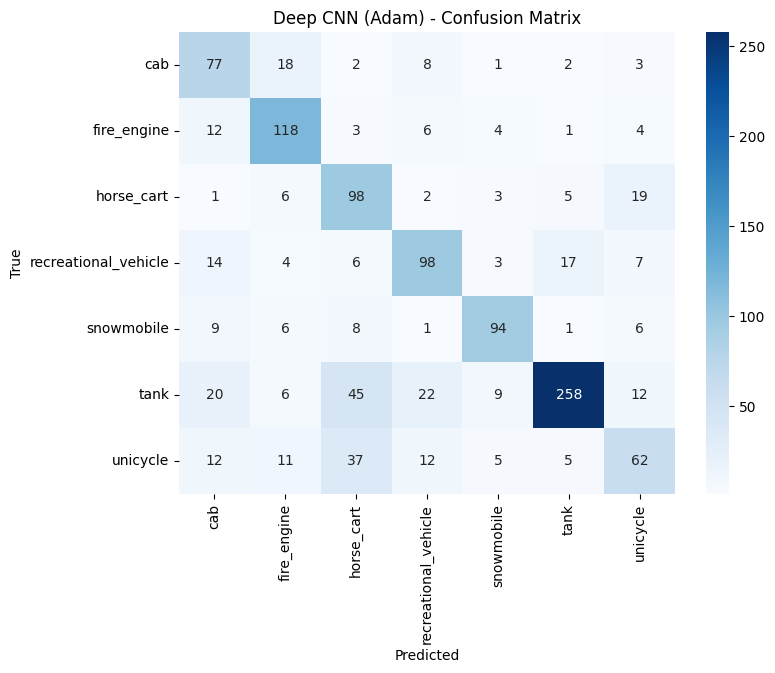

Deep CNN (Adam) - Classification Report:
                      precision    recall  f1-score   support

                 cab       0.53      0.69      0.60       111
         fire_engine       0.70      0.80      0.74       148
          horse_cart       0.49      0.73      0.59       134
recreational_vehicle       0.66      0.66      0.66       149
          snowmobile       0.79      0.75      0.77       125
                tank       0.89      0.69      0.78       372
            unicycle       0.55      0.43      0.48       144

            accuracy                           0.68      1183
           macro avg       0.66      0.68      0.66      1183
        weighted avg       0.71      0.68      0.68      1183

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step


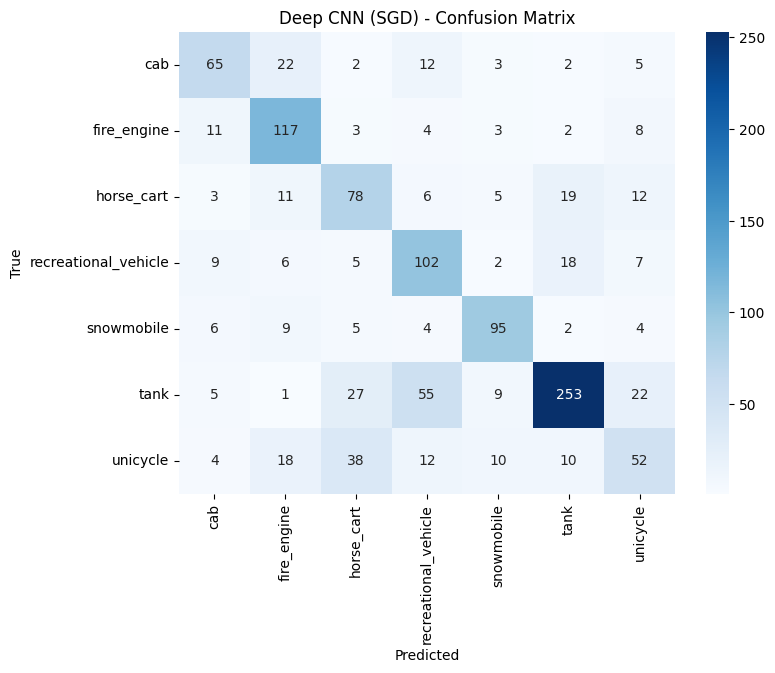

Deep CNN (SGD) - Classification Report:
                      precision    recall  f1-score   support

                 cab       0.63      0.59      0.61       111
         fire_engine       0.64      0.79      0.70       148
          horse_cart       0.49      0.58      0.53       134
recreational_vehicle       0.52      0.68      0.59       149
          snowmobile       0.75      0.76      0.75       125
                tank       0.83      0.68      0.75       372
            unicycle       0.47      0.36      0.41       144

            accuracy                           0.64      1183
           macro avg       0.62      0.63      0.62      1183
        weighted avg       0.66      0.64      0.64      1183



In [ ]:
# Get predictions
def evaluate_model_metrix(model, test_generator, class_names, title="Model"):
    y_pred_probs = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(f"{title} - Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

class_names = list(test_generator.class_indices.keys())

evaluate_model_metrix(baseline_model, test_generator, class_names, title="Baseline CNN")
evaluate_model_metrix(deep_model_adam, test_generator, class_names, title="Deep CNN (Adam)")
evaluate_model_metrix(deep_model_sgd, test_generator, class_names, title="Deep CNN (SGD)")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step


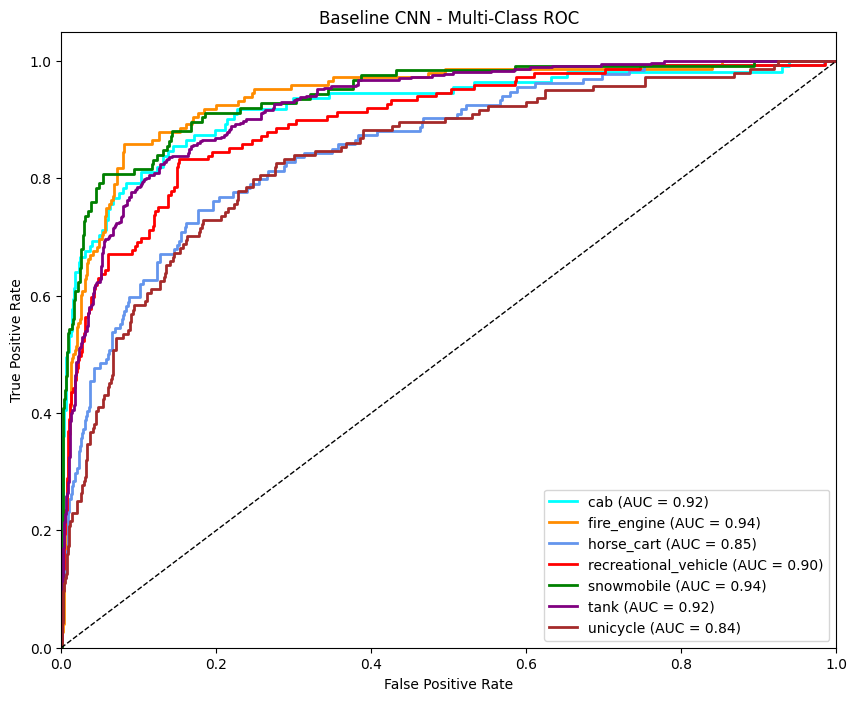

19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 602ms/step


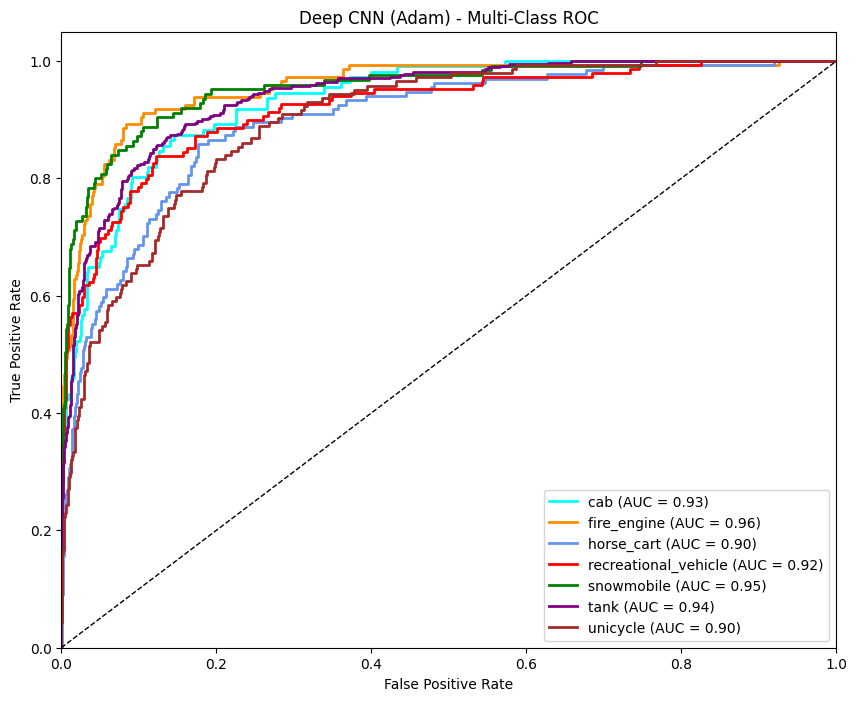

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step


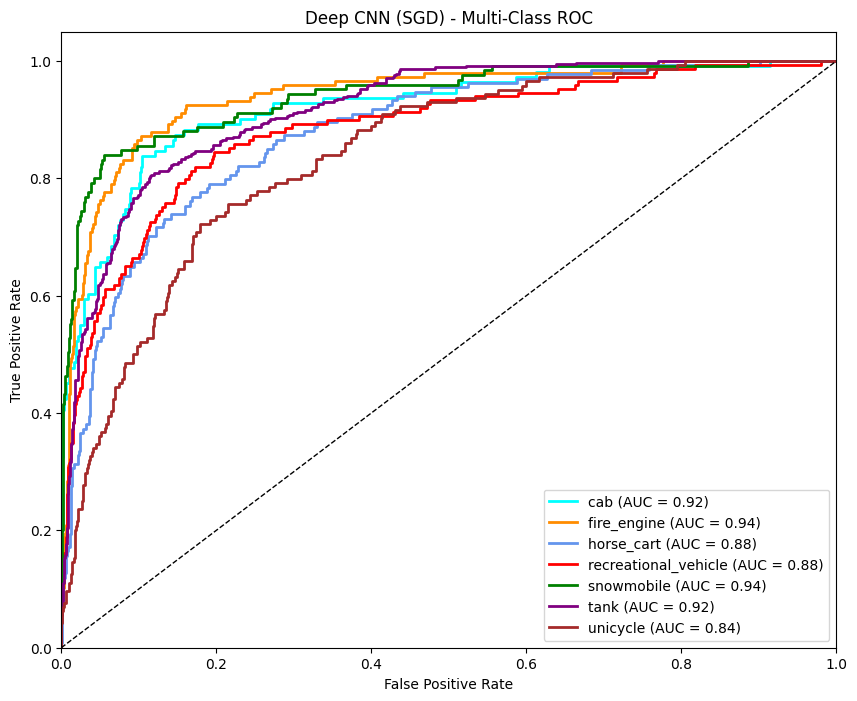

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle


def plot_multiclass_roc(model, test_generator, class_names, title='ROC Curve'):
    # Ground truth and predicted probabilities
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)

    # Binarize the output
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} - Multi-Class ROC')
    plt.legend(loc='lower right')
    plt.show()


plot_multiclass_roc(baseline_model, test_generator, class_names, title="Baseline CNN")
plot_multiclass_roc(deep_model_adam, test_generator, class_names, title="Deep CNN (Adam)")
plot_multiclass_roc(deep_model_sgd, test_generator, class_names, title="Deep CNN (SGD)")

# Part B: Transfer Learning with MobileNetV2

# Step 1: Adjust Data Generators for Transfer Learning

In [ ]:
# -----------------------------------------------
# Part B: Transfer Learning - Data Preparation
# Using 128x128 since MobileNetV2 supports it
# -----------------------------------------------

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Re-define generators for MobileNetV2
train_tl_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Updated Generators
train_tl_generator = train_tl_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_tl_generator = val_tl_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_tl_generator = test_tl_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8698 images belonging to 7 classes.
Found 2459 images belonging to 7 classes.
Found 1183 images belonging to 7 classes.


# Step 2: Load and Customize Pretrained MobileNetV2

In [ ]:
# ---------------------------------------------------
# Load MobileNetV2 and add custom classification head
# ---------------------------------------------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def create_transfer_model():
    base_model = MobileNetV2(include_top=False,
                             input_shape=(128, 128, 3),
                             weights='imagenet')

    # Freeze base model for feature extraction
    base_model.trainable = False

    # Add new top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

transfer_model = create_transfer_model()
transfer_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 3: Train (Feature Extraction Phase)

In [ ]:
# ------------------------------------
# Train Only the Custom Classification Head
# ------------------------------------
history_transfer = train_model(transfer_model, 'transfer_model_mobilenetv2')


Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 112s 804ms/step - accuracy: 0.2788 - loss: 2.1107 - val_accuracy: 0.8425 - val_loss: 0.7603 - learning_rate: 1.0000e-04
Epoch 2/30
  1/135 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.5469 - loss: 1.2995

/mnt/c/Users/PREDATOR/OneDrive/Documents/AI and training/myenv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.5469 - loss: 1.2995 - val_accuracy: 0.8446 - val_loss: 0.7574 - learning_rate: 1.0000e-04
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 106s 785ms/step - accuracy: 0.5731 - loss: 1.2001 - val_accuracy: 0.8993 - val_loss: 0.4215 - learning_rate: 1.0000e-04
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.6094 - loss: 1.1033 - val_accuracy: 0.8988 - val_loss: 0.4206 - learning_rate: 1.0000e-04
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 111s 825ms/step - accuracy: 0.6588 - loss: 0.9759 - val_accuracy: 0.9104 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - accuracy: 0.6875 - loss: 0.8926 - val_accuracy: 0.9104 - val_loss: 0.3184 - learning_rate: 1.0000e-04
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 118s 871ms/step - accuracy: 0.7029 - loss: 0.8499 - val_accuracy: 0.9145 - val_loss: 0.2734 - learning_rate: 1.0000e-04
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step

# Step 4: Fine-Tune Model

In [ ]:
# ------------------------------------------
# Unfreeze Top Layers and Fine-Tune Model
# ------------------------------------------
# Unfreeze last 20 layers
for layer in transfer_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):  # Skip BatchNorm for stability
        layer.trainable = True

transfer_model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Fine-tune the model
history_finetuned = train_model(transfer_model, 'transfer_model_finetuned')


Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.7925 - loss: 0.6047 - val_accuracy: 0.9317 - val_loss: 0.1978 - learning_rate: 1.0000e-05
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - accuracy: 0.8281 - loss: 0.5698 - val_accuracy: 0.9317 - val_loss: 0.1970 - learning_rate: 1.0000e-05
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 134s 994ms/step - accuracy: 0.8022 - loss: 0.5722 - val_accuracy: 0.9350 - val_loss: 0.1872 - learning_rate: 1.0000e-05
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.6250 - loss: 1.1063 - val_accuracy: 0.9342 - val_loss: 0.1888 - learning_rate: 1.0000e-05
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 134s 990ms/step - accuracy: 0.8017 - loss: 0.5805 - val_accuracy: 0.9391 - val_loss: 0.1899 - learning_rate: 1.0000e-05
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.8438 - loss: 0.5198 - val_accuracy: 0.9391 - val_loss: 0.1912 - learning_rate: 1.0000e-05
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 136s 1

# Step 5: Evaluate Transfer Learning Models


Evaluating Transfer Learning Model (MobileNetV2)
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 701ms/step - accuracy: 0.9435 - loss: 0.1582
Transfer Learning Model (MobileNetV2) - Test Accuracy: 95.44%
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 756ms/step
                      precision    recall  f1-score   support

                 cab       0.90      0.93      0.91       111
         fire_engine       0.94      0.94      0.94       148
          horse_cart       0.95      0.95      0.95       134
recreational_vehicle       0.97      0.94      0.96       149
          snowmobile       0.98      0.96      0.97       125
                tank       0.97      0.98      0.98       372
            unicycle       0.93      0.94      0.94       144

            accuracy                           0.95      1183
           macro avg       0.95      0.95      0.95      1183
        weighted avg       0.95      0.95      0.95      1183



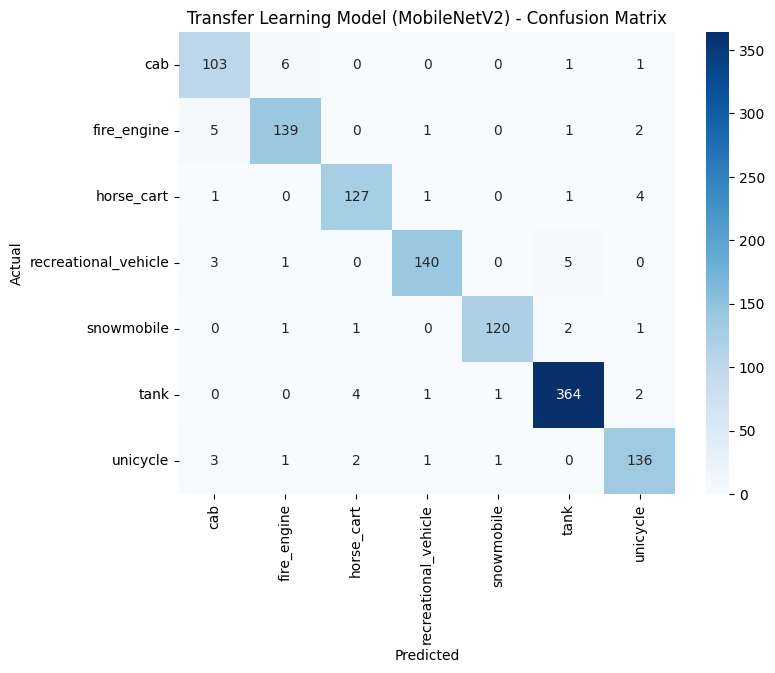

In [ ]:
evaluate_model(transfer_model, "Transfer Learning Model (MobileNetV2)")

# Step 6: Plot History

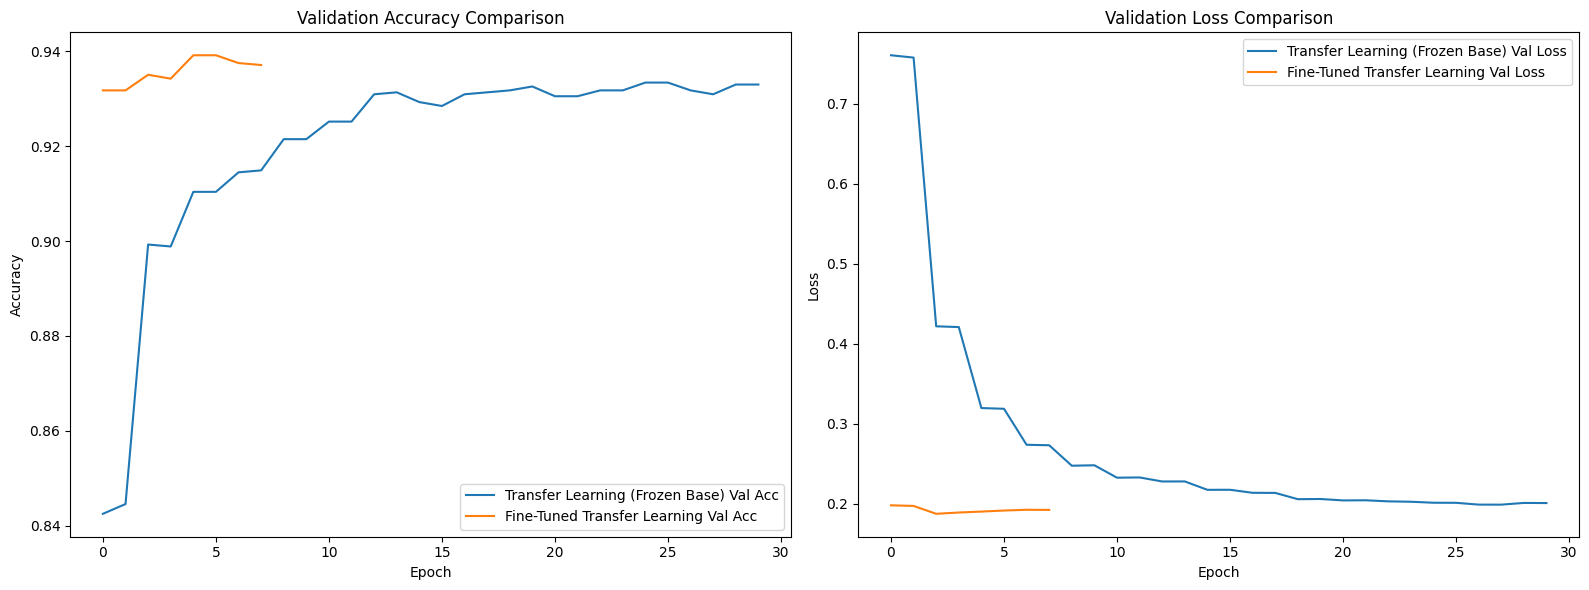

In [ ]:
# Plot fine-tuned and original transfer learning performance
plot_all_histories(
    [history_transfer, history_finetuned],
    ['Transfer Learning (Frozen Base)', 'Fine-Tuned Transfer Learning']
)
